# DIGITAL ASSIGNMENT 6
### NAME SIDHANTHA PODDAR
### REG 17BCE2044

# BOOK RECOMMENDATION

In [2]:
#!/usr/bin/env python3

import pandas as pd
import numpy as np
from collections import defaultdict
import surprise
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
train = pd.read_csv('train.csv')
train

,Unnamed: 0,User-ID,ISBN,Book-Rating
0,1465,277427,0060542128,7
1,1474,277427,0061009059,9
2,1522,277427,0316776963,8
3,1543,277427,0345413903,10
4,1564,277427,0380702843,8
5,1570,277427,0380791978,9
6,1578,277427,0385424736,9
7,1581,277427,0385486804,9
8,1583,277427,0385503857,9
9,1584,277427,0385504209,8


In [17]:
train.shape

(37548, 4)

In [3]:
def precision_recall_at_k(predictions, k, threshold):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        
        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        #f_score = (2*precision*recall)/(precision+recall)
        
    return precision, recall#, f_score

In [4]:
def ndcg_at_k(predictions, k):
    dcgs = dict()
    idcgs = dict()
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
        
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        #estimated rank
        rank_est = np.arange(1, len(user_ratings[:k])+1)
        discount_est = np.log2(rank_est+1)
        
        #Relevance 
        rel = [np.power(2,true_r)-1 for (_, true_r) in user_ratings[:k]]
        
        dcgs[uid] = sum(rel/discount_est)
        
        # Sort user ratings by true value
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        
        #estimated rank
        rank_true = np.arange(1, len(user_ratings[:k])+1)
        discount_true = np.log2(rank_true+1)
        
        #Relevance 
        rel_true = [np.power(2,true_r)-1 for (_, true_r) in user_ratings[:k]]
        
        idcgs[uid] = sum(rel_true/discount_true)
        
    dcg = sum(dcgu for (_,dcgu) in dcgs.items())
    idcg = sum(idcgu for (_,idcgu) in idcgs.items())
    return dcg/idcg

In [5]:
train = pd.read_csv('train.csv') 

reader = surprise.Reader(rating_scale=(1, 10))
data = surprise.Dataset.load_from_df(train[['User-ID', 'ISBN', 'Book-Rating']], reader)

In [6]:
# Tunning on number of factors and learning rate
factors = [5,10,15,20,50]
learning_rates = [0.0001, 0.001, 0.01, 0.02, 0.05]

In [7]:
m = len(factors)
n = len(learning_rates)
test_ndcg = np.zeros((m,n))
train_ndcg = np.zeros((m,n))
test_precision = np.zeros((m,n))
train_precision = np.zeros((m,n))
test_recall = np.zeros((m,n))
train_recall = np.zeros((m,n))
train_f_score = np.zeros((m,n))
test_f_score = np.zeros((m,n))
k = 10
threshold = 7

In [8]:
for i in range(len(factors)):
    for j in range(len(learning_rates)):
        fact = factors[i]
        rate = learning_rates[j]
        print ('\n No. of factors:{}, learning rate:{}'.format(fact, rate))
        data.split(n_folds=4)
        algo = surprise.SVD(n_factors = fact, lr_all = rate)#n_factors = , lr_all =, reg_all =
        
        
        precisions_train = []
        recalls_train = []
        f_scores_train = []
        ndcgs_train = []

        precisions_test = []
        recalls_test = []
        f_scores_test = []
        ndcgs_test = []
        
        for trainset, testset in data.folds():

            algo.train(trainset)

            predictions_train = algo.test(trainset.build_testset())
            precision_train, recall_train= precision_recall_at_k(predictions_train, k, threshold)
            ndcg_train = ndcg_at_k(predictions_train, k)

            precisions_train.append(precision_train)
            recalls_train.append(recall_train)
            f= 2*precision_train*recall_train/(precision_train+recall_train)
            f_scores_train.append(f)
            ndcgs_train.append(ndcg_train)


            predictions_test = algo.test(testset)
            precision_test, recall_test = precision_recall_at_k(predictions_test, k, threshold)
            ndcg_test = ndcg_at_k(predictions_test, k)

            precisions_test.append(precision_test)
            recalls_test.append(recall_test)
            f= 2*precision_test*recall_test/(precision_test+recall_test)
            f_scores_test.append(f)
            ndcgs_test.append(ndcg_test)    


        print ("\n Training Set accuracy:")
        print ("Precision: {}".format(np.mean(precisions_train)))
        train_precision[i,j]=np.mean(precisions_train)
        print ("Recall: {}".format(np.mean(recalls_train)))
        train_recall[i,j]=np.mean(recalls_train)
        print ("F-Score: {}".format(np.mean(f_scores_train)))
        train_f_score[i,j]=np.mean(f_scores_train)
        print ("NDCG: {}".format(np.mean(ndcgs_train)))
        train_ndcg[i,j]=np.mean(ndcgs_train)

        print ("\n Test Set accuracy:")
        print ("Precision: {}".format(np.mean(precisions_test)))
        test_precision[i,j]=np.mean(precisions_test)
        print ("Recall: {}".format(np.mean(recalls_test)))
        test_recall[i,j]=np.mean(recalls_test)
        print ("F-Score: {}".format(np.mean(f_scores_test)))
        test_f_score[i,j]=np.mean(f_scores_test)
        print ("NDCG: {}".format(np.mean(ndcgs_test)))
        test_ndcg[i,j]=np.mean(ndcgs_test)


 No. of factors:5, learning rate:0.0001


C:\Users\Sid\AppData\Local\conda\conda\envs\cten\lib\site-packages\surprise\dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)
C:\Users\Sid\AppData\Local\conda\conda\envs\cten\lib\site-packages\surprise\prediction_algorithms\algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)



 Training Set accuracy:
Precision: 0.8498747708573104
Recall: 0.6379219607189309
F-Score: 0.728800628583746
NDCG: 0.715036368284687

 Test Set accuracy:
Precision: 0.8218327139347671
Recall: 0.9182669341398849
F-Score: 0.8673756214944803
NDCG: 0.7968733667339462

 No. of factors:5, learning rate:0.001

 Training Set accuracy:
Precision: 0.8829744319392901
Recall: 0.6528810070421077
F-Score: 0.7506904058926993
NDCG: 0.7856417770817115

 Test Set accuracy:
Precision: 0.8329116511121986
Recall: 0.9125801561509139
F-Score: 0.8709266244482143
NDCG: 0.8193942569304787

 No. of factors:5, learning rate:0.01

 Training Set accuracy:
Precision: 0.9466612667149803
Recall: 0.61368169617078
F-Score: 0.7446395979393016
NDCG: 0.861626665890804

 Test Set accuracy:
Precision: 0.8614909841008838
Recall: 0.819357409273539
F-Score: 0.8398740673141869
NDCG: 0.8221503207143019

 No. of factors:5, learning rate:0.02

 Training Set accuracy:
Precision: 0.9754900811413793
Recall: 0.6335667254383348
F-Score:

In [9]:
test_f_score

array([[0.86737562, 0.87092662, 0.83987407, 0.82272366, 0.79535801],
       [0.86756727, 0.87297251, 0.84114286, 0.8193544 , 0.80356328],
       [0.86726737, 0.87160578, 0.83938758, 0.82619842, 0.81020069],
       [0.86608887, 0.87177743, 0.84059335, 0.82654249, 0.8112668 ],
       [0.86558673, 0.87011987, 0.84156817, 0.83328702, 0.83225277]])

In [10]:
test_ndcg

array([[0.79687337, 0.81939426, 0.82215032, 0.81317833, 0.79823242],
       [0.79278898, 0.82198393, 0.81801074, 0.81068053, 0.80249387],
       [0.79345776, 0.82032413, 0.81802917, 0.81161162, 0.80361688],
       [0.78360646, 0.81963249, 0.81968758, 0.80982658, 0.80435697],
       [0.77918775, 0.81406292, 0.81854524, 0.80902097, 0.81471336]])

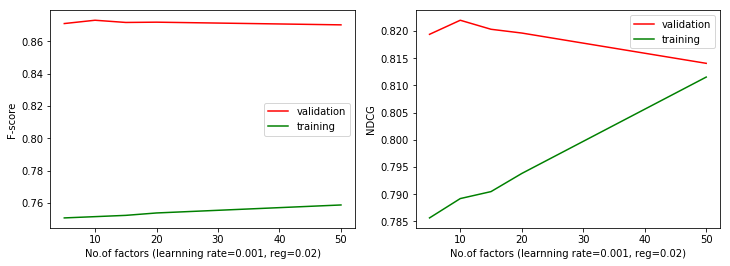

In [11]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(factors, test_f_score[:,1], 'r')
ax[0].plot(factors, train_f_score[:,1], 'g')
ax[0].set_xlabel('No.of factors (learnning rate=0.001, reg=0.02)')
ax[0].set_ylabel('F-score')
ax[0].legend(['validation','training'])
ax[1].plot(factors, test_ndcg[:,1], 'r')
ax[1].plot(factors, train_ndcg[:,1], 'g')
ax[1].set_xlabel('No.of factors (learnning rate=0.001, reg=0.02)')
ax[1].set_ylabel('NDCG')
ax[1].legend(['validation','training'])

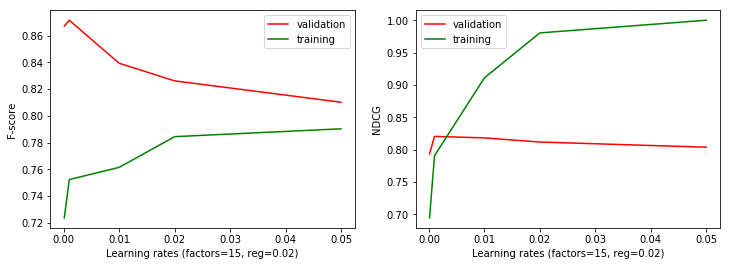

In [12]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(learning_rates, test_f_score[2,:], 'r')
ax[0].plot(learning_rates, train_f_score[2,:], 'g')
ax[0].set_xlabel('Learning rates (factors=15, reg=0.02)')
ax[0].set_ylabel('F-score')
ax[0].legend(['validation','training'])
ax[1].plot(learning_rates, test_ndcg[2,:], 'r')
ax[1].plot(learning_rates, train_ndcg[2,:], 'g')
ax[1].set_xlabel('Learning rates (factors=15, reg=0.02)')
ax[1].set_ylabel('NDCG')
ax[1].legend(['validation','training'])

#  Pearson Correlation Coefficient

In [23]:
#creating the data
data=[[9,19],[7,13],[5,12],[8,16],[6,15],[3,10],[4,8]]
#Converting into DataFrame
y=pd.DataFrame(data,columns=['Advertisement_Exp','Annual_Sales'])
#Confirming the result\
y

,Advertisement_Exp,Annual_Sales
0,9,19
1,7,13
2,5,12
3,8,16
4,6,15
5,3,10
6,4,8


In [21]:
y.head()
#Calculating the Pearson Correaltion Coefficient
y['Advertisement_Exp'].corr(y['Annual_Sales'])

0.9103664774626048